In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate
import psutil
import os
from tqdm.auto import tqdm

# 1. Choix du processeur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Appareil utilisé : {device}")

# 2. Nom du projet
PROJECT_NAME = "BERT-Sentiment-Analyzer"

Appareil utilisé : cuda


In [2]:
# Chargement du dataset IMDb (critiques de films)
print("Chargement des données...")
dataset = load_dataset("imdb")

# On réduit la taille pour un entraînement rapide en démonstration
train_set = dataset["train"].shuffle(seed=42).select(range(1000))
test_set = dataset["test"].shuffle(seed=42).select(range(500))

# Tokenisation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_set.map(tokenize_function, batched=True)
tokenized_test = test_set.map(tokenize_function, batched=True)

Chargement des données...


--- Statistiques descriptives (Train) ---
count    1000.000000
mean      231.553000
std       171.781076
min        31.000000
25%       127.000000
50%       175.000000
75%       271.000000
max      1005.000000
Name: word_count, dtype: float64


C:\Users\PAOLO\AppData\Local\Temp\ipykernel_32296\2306425705.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_train, palette='viridis')


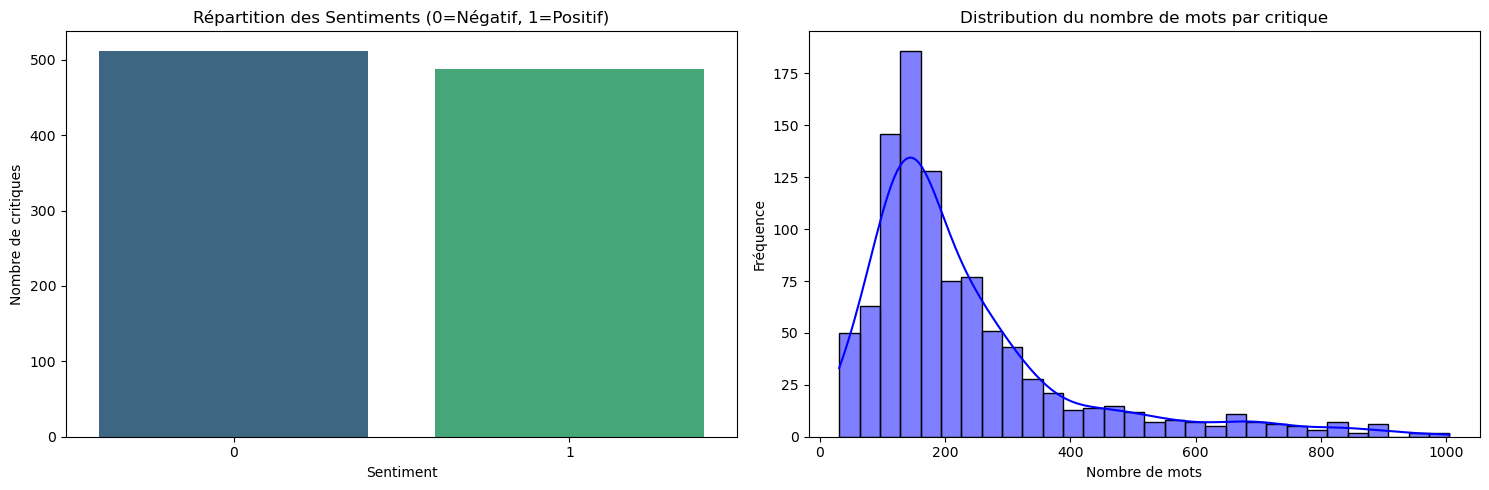

In [3]:
#analyse exploratoire
# 1. Conversion en DataFrame Pandas pour faciliter l'analyse
df_train = pd.DataFrame(train_set)
df_test = pd.DataFrame(test_set)

# 2. Calcul de la longueur des textes (nombre de mots)
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

print("--- Statistiques descriptives (Train) ---")
print(df_train['word_count'].describe())

# --- VISUALISATION ---

plt.figure(figsize=(15, 5))

# Graphique 1 : Répartition des classes (Sentiment)
# 0 = Négatif, 1 = Positif
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df_train, palette='viridis')
plt.title('Répartition des Sentiments (0=Négatif, 1=Positif)')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de critiques')

# Graphique 2 : Distribution de la longueur des textes
plt.subplot(1, 2, 2)
sns.histplot(df_train['word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution du nombre de mots par critique')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

Génération des nuages de mots...


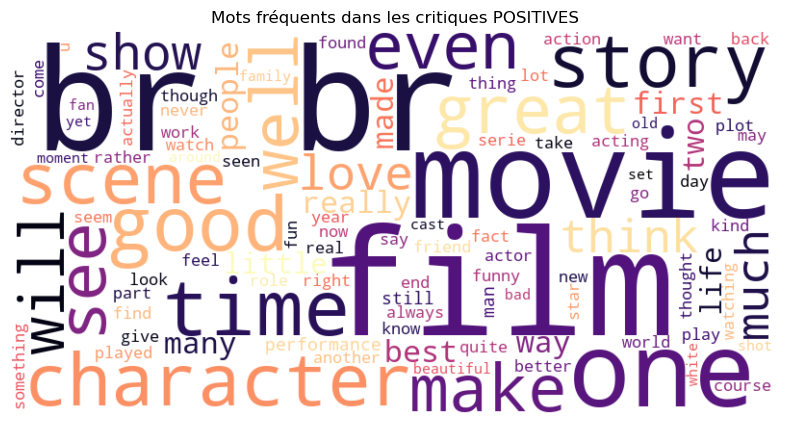

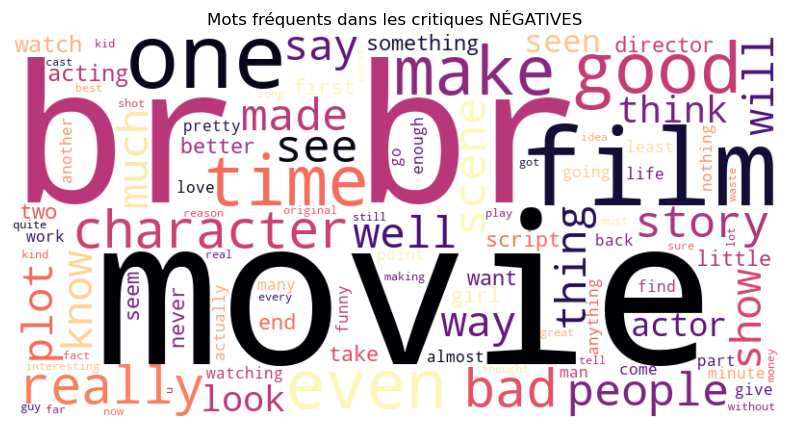

In [4]:
from wordcloud import WordCloud

def afficher_wordcloud(data, titre):
    text = " ".join(review for review in data)
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          max_words=100, colormap='magma').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titre)
    plt.show()

# Affichage pour les critiques positives (Label 1)
print("Génération des nuages de mots...")
afficher_wordcloud(df_train[df_train['label'] == 1]['text'], "Mots fréquents dans les critiques POSITIVES")

# Affichage pour les critiques négatives (Label 0)
afficher_wordcloud(df_train[df_train['label'] == 0]['text'], "Mots fréquents dans les critiques NÉGATIVES")

In [5]:
# Chargement de BERT pré-entraîné
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# Métrique de précision (Accuracy)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 1. Définition du décorateur (si tu ne l'as pas mis dans une cellule avant)
def monitor_ressources(fonction_entrainement):
    def wrapper(*args, **kwargs):
        print("--- Démarrage du Monitoring des ressources ---")
        start_time = time.time()
        process = psutil.Process(os.getpid())
        
        # État initial
        ram_init = process.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        # EXÉCUTION DE L'ENTRAÎNEMENT
        resultat = fonction_entrainement(*args, **kwargs)
        
        # Bilan final
        end_time = time.time()
        ram_final = process.memory_info().rss / (1024**2)
        temps_total = end_time - start_time
        
        print("\n" + "="*40)
        print(f"📊 BILAN DES RESSOURCES POUR {PROJECT_NAME}")
        print("="*40)
        print(f"⏱️ Temps total      : {temps_total:.2f} secondes")
        print(f"💻 Utilisation CPU   : {psutil.cpu_percent()}%")
        print(f"🧠 RAM utilisée (Mo) : {ram_final - ram_init:.2f} Mo")
        
        if torch.cuda.is_available():
            gpu_max = torch.cuda.max_memory_allocated() / (1024**2)
            print(f"🚀 GPU Max utilisé   : {gpu_max:.2f} Mo")
            print(f"🔥 Nom du GPU        : {torch.cuda.get_device_name(0)}")
        else:
            print("🚀 GPU               : Non détecté (utilisation CPU)")
        print("="*40)
        return resultat
    return wrapper

# 2. On encapsule le lancement dans une fonction pour utiliser le décorateur
@monitor_ressources
def lancer_entrainement(trainer_obj):
    return trainer_obj.train()

# 3. Configuration de l'entraînement (Ton code original)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none" # Évite d'envoyer les logs vers des services externes si non configurés
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# 4. Exécution avec monitoring
print(f"--- Début de l'entraînement global de {PROJECT_NAME} ---")
train_results = lancer_entrainement(trainer)

--- Début de l'entraînement global de BERT-Sentiment-Analyzer ---
--- Démarrage du Monitoring des ressources ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.611200,0.502862,0.764000
2,0.392600,0.440998,0.834000
3,0.272100,0.562647,0.844000



📊 BILAN DES RESSOURCES POUR BERT-Sentiment-Analyzer
⏱️ Temps total      : 1227.88 secondes
💻 Utilisation CPU   : 13.5%
🧠 RAM utilisée (Mo) : 692.36 Mo
🚀 GPU Max utilisé   : 3799.81 Mo
🔥 Nom du GPU        : NVIDIA GeForce RTX 3050 Laptop GPU


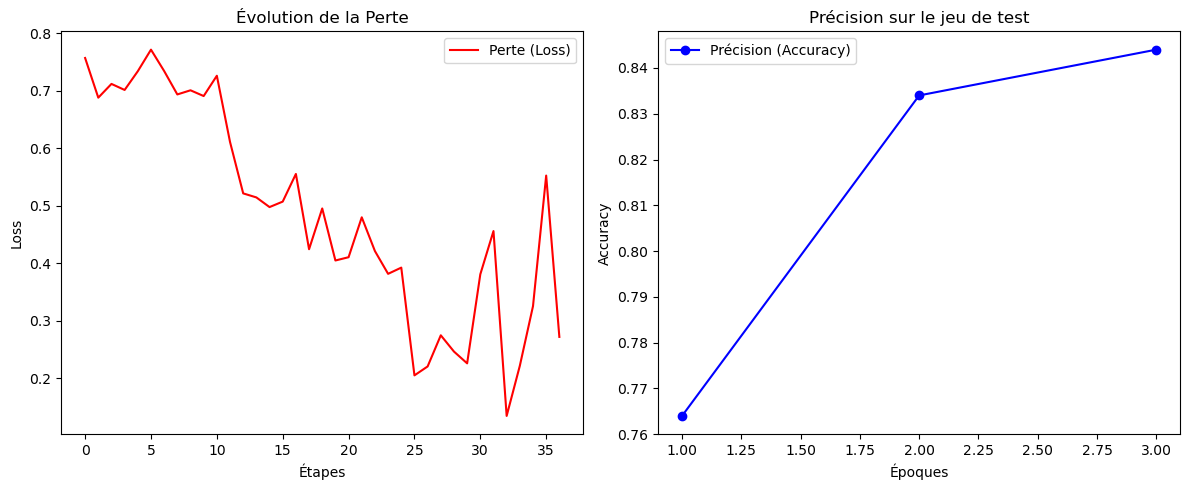

In [7]:
# Extraction des statistiques de l'historique
history = trainer.state.log_history

epochs = []
train_loss = []
eval_accuracy = []

for entry in history:
    if 'loss' in entry and 'epoch' in entry:
        epochs.append(entry['epoch'])
        train_loss.append(entry['loss'])
    if 'eval_accuracy' in entry:
        eval_accuracy.append(entry['eval_accuracy'])

# Création du graphique
plt.figure(figsize=(12, 5))

# Sous-graphe 1 : Perte
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Perte (Loss)', color='red')
plt.title('Évolution de la Perte')
plt.xlabel('Étapes')
plt.ylabel('Loss')
plt.legend()

# Sous-graphe 2 : Précision
plt.subplot(1, 2, 2)
plt.plot(range(1, len(eval_accuracy)+1), eval_accuracy, marker='o', label='Précision (Accuracy)', color='blue')
plt.title('Précision sur le jeu de test')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

>>> TEST 1 : PHRASE COURTE

--- Analyse de texte (20 tokens détectés) ---
RÉSULTAT GLOBAL : POSITIF (97.38% de confiance)


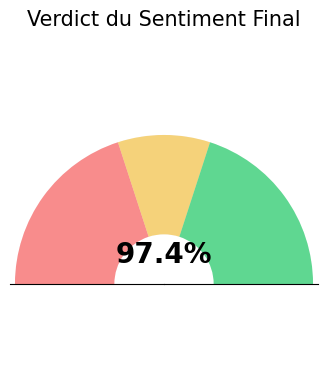

Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors



>>> TEST 2 : TEXTE LONG (Dépassement de 512 tokens)

--- Analyse de texte (799 tokens détectés) ---


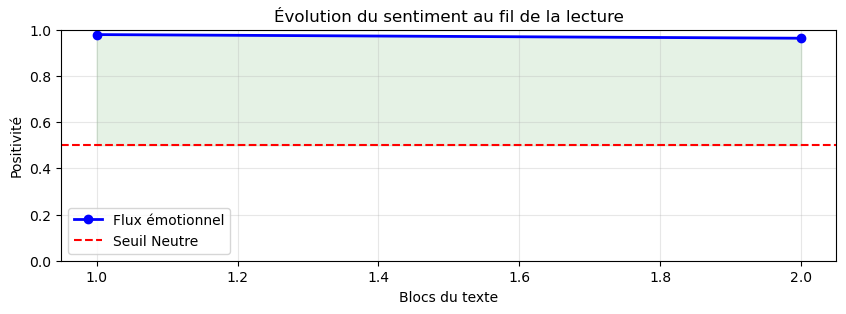

RÉSULTAT GLOBAL : POSITIF (97.11% de confiance)


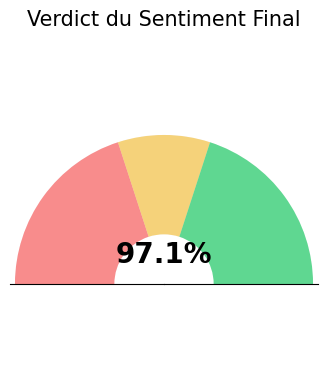

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. OUTIL DE VISUALISATION : LA JAUGE
# ==========================================
def afficher_jauge_sentiment(score):
    # Création de la figure
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': 'polar'})
    
    # Configuration de l'arc (demi-cercle)
    ax.set_theta_zero_location("W") # Ouest = Début (0%)
    ax.set_theta_direction(-1)      # Sens horaire
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    
    # Définition des zones de couleur
    colors = ['#ff4b4b', '#fbc02d', '#00c853'] # Rouge, Jaune, Vert
    ax.barh(0.5, np.radians(180), left=0, height=0.5, color='#eeeeee') # Fond gris
    
    # Tracé des zones colorées
    ax.barh(0.5, np.radians(72), left=0, height=0.5, color=colors[0], alpha=0.6)      # Zone Rouge
    ax.barh(0.5, np.radians(36), left=np.radians(72), height=0.5, color=colors[1], alpha=0.6) # Zone Jaune
    ax.barh(0.5, np.radians(72), left=np.radians(108), height=0.5, color=colors[2], alpha=0.6) # Zone Verte

    # L'aiguille
    angle_aiguille = np.radians(score * 180)
    ax.annotate('', xy=(angle_aiguille, 1.0), xytext=(0, 0),
                arrowprops=dict(arrowstyle="wedge,tail_width=0.5", color="black", shrinkA=0))
    
    # Décorations et labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    
    # Texte du score au centre
    plt.text(np.radians(90), 0.15, f"{score*100:.1f}%", 
             fontsize=20, fontweight='bold', ha='center', va='center')
    
    plt.title("Verdict du Sentiment Final", fontsize=15, pad=20)
    plt.show()

# ==========================================
# 2. MOTEUR D'ANALYSE (SUPER ANALYSE)
# ==========================================
def super_analyse_optimisee(texte):
    model.eval()
    
    # Tokenisation et découpage en blocs de 512
    inputs = tokenizer(texte, return_tensors="pt", add_special_tokens=True).to(device)
    input_ids = inputs['input_ids'][0]
    chunks = input_ids.split(512)
    
    scores_positifs = [] 
    
    print(f"\n--- Analyse de texte ({len(input_ids)} tokens détectés) ---")
    
    with torch.no_grad():
        for chunk in chunks:
            chunk = chunk.unsqueeze(0).to(device) 
            outputs = model(chunk)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            score_positif = probs[0][1].item()
            scores_positifs.append(score_positif)
    
    # Calcul du score final (moyenne)
    score_final_moyen = np.mean(scores_positifs)
    classe_finale = 1 if score_final_moyen >= 0.5 else 0
    label = "POSITIF" if classe_finale == 1 else "NÉGATIF"
    confiance_affichage = score_final_moyen if classe_finale == 1 else (1 - score_final_moyen)
    
    # ÉTAPE A : AFFICHAGE DE LA COURBE (Détails)
    if len(scores_positifs) > 1:
        plt.figure(figsize=(10, 3))
        plt.plot(range(1, len(scores_positifs) + 1), scores_positifs, 'b-o', linewidth=2, label='Flux émotionnel')
        plt.axhline(y=0.5, color='r', linestyle='--', label='Seuil Neutre')
        
        # Coloration des zones de la courbe
        points = np.array(scores_positifs)
        plt.fill_between(range(1, len(scores_positifs) + 1), 0.5, points, 
                         where=(points >= 0.5), color='green', alpha=0.1, interpolate=True)
        plt.fill_between(range(1, len(scores_positifs) + 1), 0.5, points, 
                         where=(points < 0.5), color='red', alpha=0.1, interpolate=True)
        
        plt.title("Évolution du sentiment au fil de la lecture")
        plt.ylabel("Positivité")
        plt.xlabel("Blocs du texte")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    # ÉTAPE B : AFFICHAGE DU RÉSULTAT ET DE LA JAUGE
    print(f"RÉSULTAT GLOBAL : {label} ({confiance_affichage*100:.2f}% de confiance)")
    afficher_jauge_sentiment(score_final_moyen)

# ==========================================
# 3. DONNÉES DE TEST
# ==========================================
petit_texte = "This movie was absolutely amazing, I loved the acting! The cinematography was top-notch."

texte_long_512 = """
L'expédition dans les montagnes de l'Himalaya avait commencé comme un rêve éveillé, une aventure 
absolument extraordinaire que je n'oublierai jamais de ma vie. Dès les premiers pas sur les sentiers 
escarpés, j'ai ressenti une joie immense et une connexion profonde avec la nature sauvage. Les 
paysages étaient d'une beauté à couper le souffle, avec des sommets enneigés qui brillaient sous un 
soleil radieux et pur. Chaque matin, le lever du soleil transformait l'horizon en un océan d'or et 
de pourpre, créant une atmosphère magique et apaisante. Nos guides étaient d'une gentillesse 
incroyable, toujours souriants et prêts à partager leurs connaissances fascinantes sur la culture 
locale. Les repas partagés autour du feu étaient délicieux et réconfortants. Tout était parfait, 
sublime et merveilleux. Je me sentais vivant, heureux et en parfaite harmonie avec l'univers. 
""" + " C'était vraiment le paradis sur terre et j'étais comblé. " * 15 + """
MALHEUREUSEMENT, tout a basculé dans l'horreur absolue peu après. Le temps est devenu catastrophique, 
une tempête effroyable a détruit nos tentes et nous avons tout perdu. C'était un cauchemar total. 
Le froid était insupportable, la nourriture a pourri et l'organisation est devenue inexistante. 
Je déteste cette expérience, c'est la pire décision de ma vie. C'est une honte, une débâcle 
complète et je conseille à tout le monde de fuir cette agence de voyage médiocre. Je suis 
furieux, déçu et profondément traumatisé par cette gestion lamentable et dangereuse. C'est un 
désastre sans nom, une expérience toxique et révoltante que je regrette amèrement. C'est nul !
"""

# ==========================================
# 4. EXÉCUTION
# ==========================================
print(">>> TEST 1 : PHRASE COURTE")
super_analyse_optimisee(petit_texte)

print("\n" + "="*50)

print(">>> TEST 2 : TEXTE LONG (Dépassement de 512 tokens)")
super_analyse_optimisee(texte_long_512)

In [28]:
model.save_pretrained("./mon_modele_bert_sentiment")
tokenizer.save_pretrained("./mon_modele_bert_sentiment")
print("Modèle et Tokenizer sauvegardés dans le dossier 'Transformers./mon_modele_bert_sentiment'")

Modèle et Tokenizer sauvegardés dans le dossier 'Transformers./mon_modele_bert_sentiment'
